## Persiapan Awal

Import Library penting

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAccuracy, MulticlassConfusionMatrix
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from collections import Counter
import numpy as np
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
from collections import Counter
import hashlib
from tqdm import tqdm


c:\Users\justi\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Gunakan GPU (jika tersedia) bawaan perangkat

In [2]:
Device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(Device)

cuda


Download dataset dari Kaggle

In [3]:
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\justi\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8


Siapkan folder dataset utama (berisi folder per kelas beserta kumpulan gambarnya)

In [4]:
MainFolderPath = os.listdir(path)
MainFolder = os.path.join(path, MainFolderPath[0])

## Exploratory Data Analysis

Exploratory Data Analysis merupakan tahapan penting sebelum membersihkan dan memanipulasi data. Kita tidak bisa membersihkan data jika kita saja tidak "kenal dekat" dengan dataset kita. Exploratory Data Analysis berguna untuk mengenali seperti apakah dataset kita. Berikut merupakan lima cara yang diambil untuk melakukan Exploratory Data Analysis

### Periksa Distribusi Tiap Kelas

Langkah awal untuk melihat apakah distribusi data seimbang atau tidak. Dalam Exploratory Data Analysis, pemeriksaan distribusi data dapat dikatakan sebagai langkah yang wajib dan awal

In [5]:
classes = os.listdir(MainFolder)
counts = {cls: len(os.listdir(os.path.join(MainFolder, cls))) for cls in classes}
ClassDist = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
ClassDist.sort_values('count', ascending=False)

,count
clothes,5327
glass,3061
plastic,1984
shoes,1977
cardboard,1825
paper,1680
metal,1020
biological,997
trash,947
battery,944


Versi divisualisasikan melalui Bar-Plot

<Axes: >

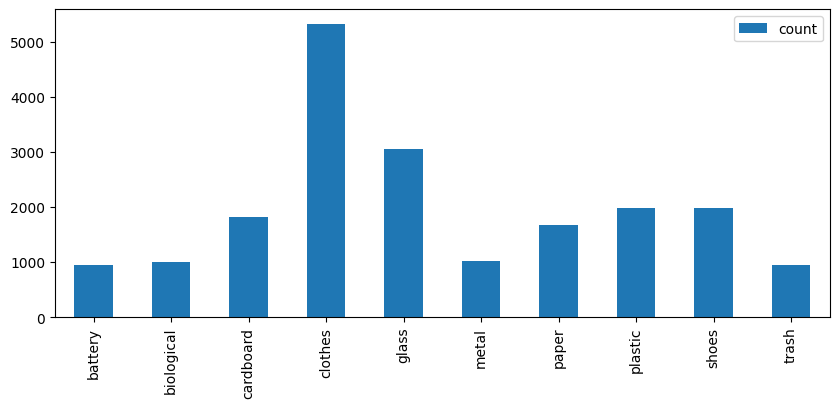

In [6]:
ClassDist.plot(kind='bar', figsize=(10,4))

Berdasarkan hasil plot, distribusi dataset bisa dikatakan tidak seimbang. Dapat dilihat bahwa kebanyakan kelas berjumlah 1000 - 2000 data sedangkan ada kelas yang jumlah datanya sangat banyak, seperti clothes yang meraih jumlah data sebanyak lebih dari 5000 data

### Preview Data per Kelas Secara Acak

Selain memberikan gambaran mengenai seperti apa data tiap kelasnya, preview data gambar membantu memastikan bahwa gambar berada dalam folder yang tepat, seperti gambar baterai yang harus berada dalam folder baterai

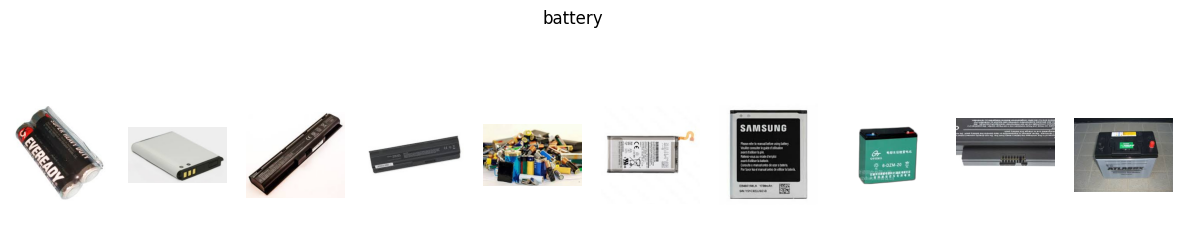

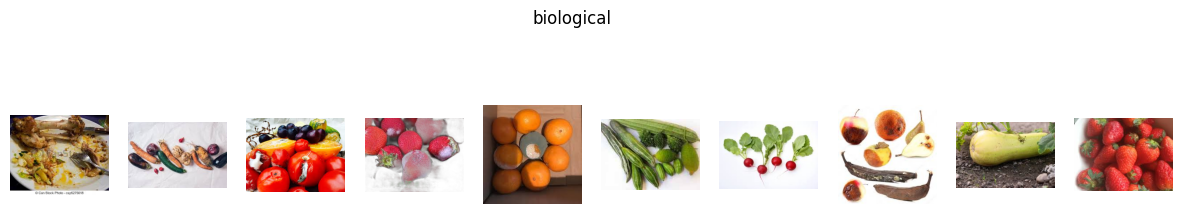

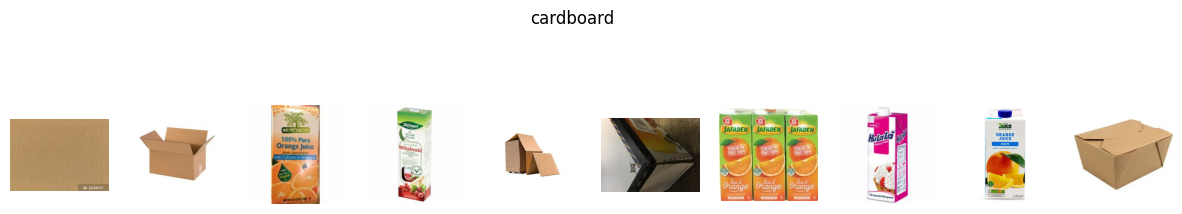

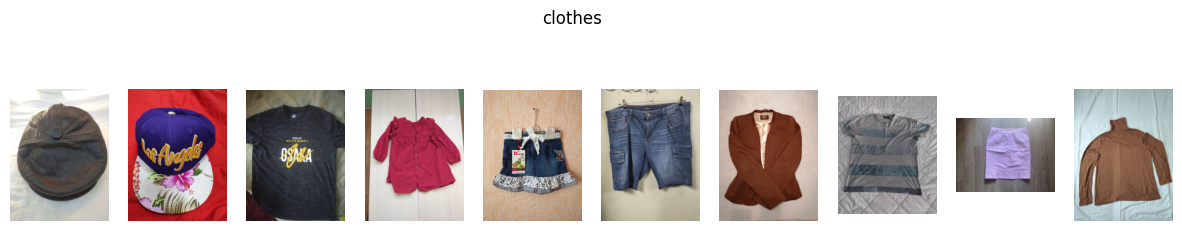

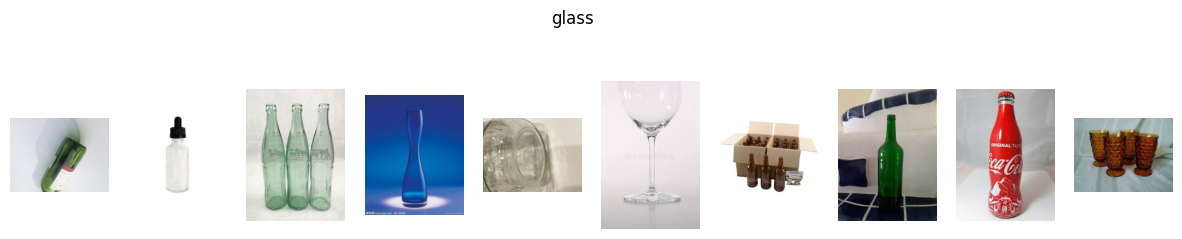

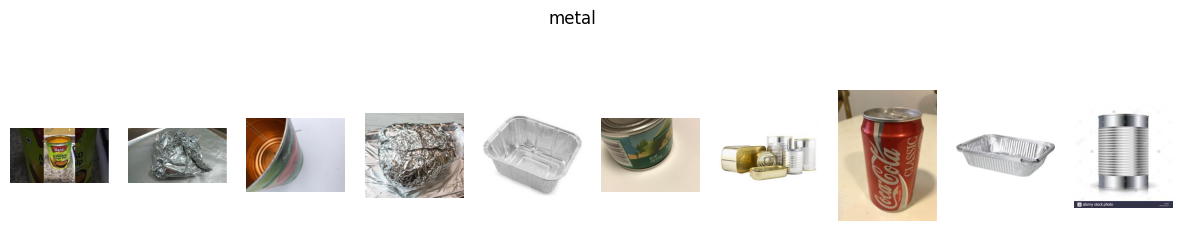

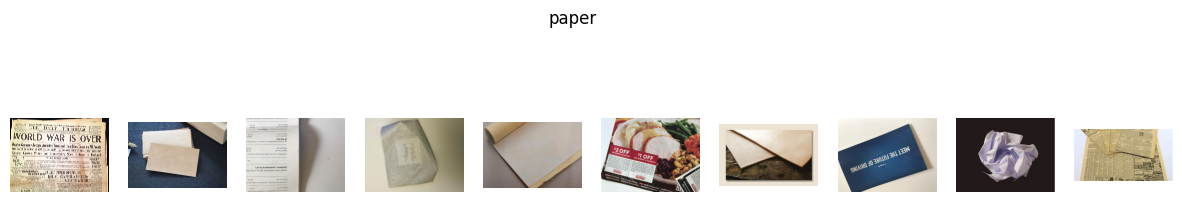

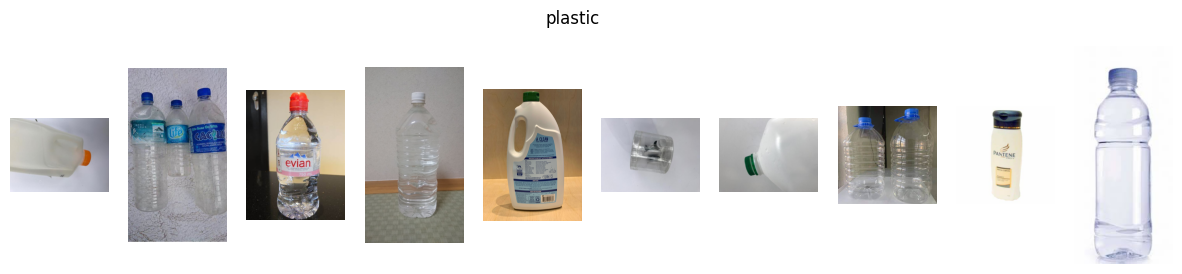

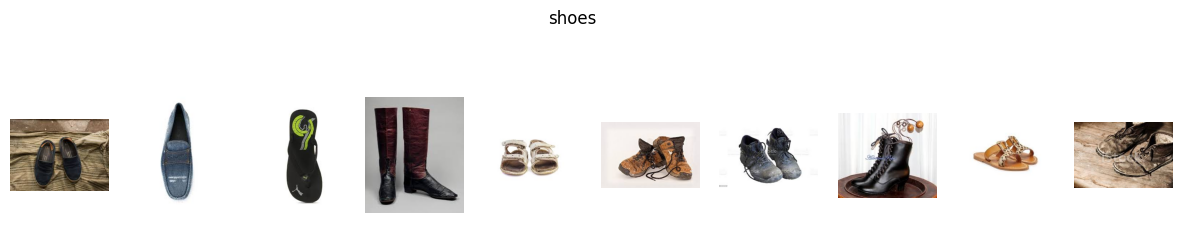

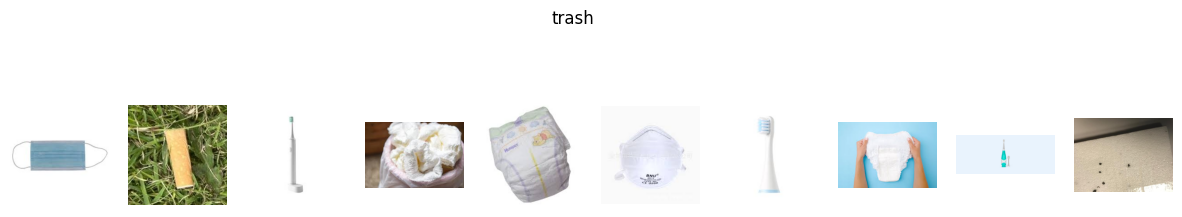

In [7]:
for ImageFolder in classes:
    ImagePath = os.path.join(MainFolder, ImageFolder)
    image = os.listdir(ImagePath)
    samples = random.sample(image, 10)

    figure, axis = plt.subplots(1, 10, figsize=(15,3))
    figure.suptitle(ImageFolder)

    for i, imgname in enumerate(samples):
        imgage = Image.open(os.path.join(ImagePath, imgname))
        axis[i].imshow(imgage)
        axis[i].axis("off")

    plt.show()

Berdasarkan preview, tiap gambar telah ditempatkan pada folder yang benar. Meskipun gambarnya berbeda-beda, namun mereka tetap dalam satu folder yang benar dan tepat

### Periksa Distribusi Ukuran Gambar

Hampir dalam kasus dunia nyata, data gambar tidak konsisten dalam hal dimensi/ukuran gambar. Hal ini dapat memengaruhi kinerja model CNN karena model tersebut memerlukan dimensi gambar yang konsisten. 

In [8]:
ImageSize = []

for ImageFolder in classes:
    ImageFolderPath = os.path.join(MainFolder, ImageFolder)
    for ImageName in os.listdir(ImageFolderPath):
        images = Image.open(os.path.join(ImageFolderPath, ImageName))
        ImageSize.append(images.size)

Counter(ImageSize).most_common(10)

[((400, 533), 2591),
 ((512, 384), 2524),
 ((225, 225), 1924),
 ((400, 534), 1077),
 ((275, 183), 671),
 ((259, 194), 521),
 ((533, 400), 387),
 ((400, 711), 300),
 ((474, 474), 240),
 ((194, 259), 219)]

Data tersebut menunjukan 10 dimensi gambar yang paling sering muncul dengan kemunculan terbesar ada pada ukuran 400 x 533 yang dimiliki oleh total 2591 gambar

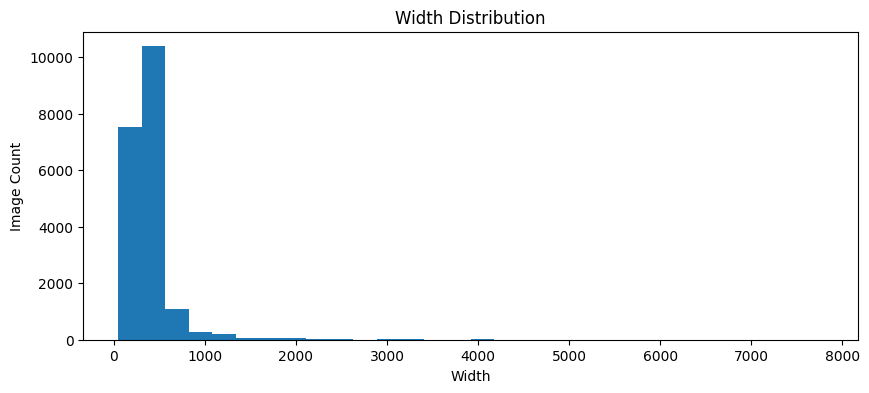

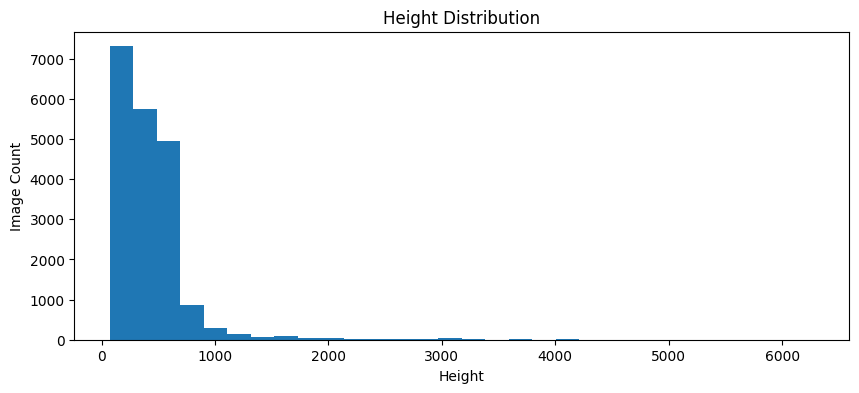

In [9]:
width = [size[0] for size in ImageSize]
height = [size[1] for size in ImageSize]

plt.figure(figsize=(10,4))
plt.hist(width, bins=30)
plt.title("Width Distribution")
plt.xlabel("Width")
plt.ylabel("Image Count")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(height, bins=30)
plt.title("Height Distribution")
plt.xlabel("Height")
plt.ylabel("Image Count")
plt.show()

Lalu, diagram di atas menunjukan bahwa distribusi panjang dan lebar gambar secara terpisah cukup variatif yang artinya penyebaran dimensi gambar cukup bervariasi dan tidak konsisten

### Periksa Duplikat

Pemeriksaan data duplikat dilakukan menggunakan Hash Tables seperti berikut

In [10]:
HashTable = set()
Duplicates = 0

for ImageFolder in classes:
    ImageFolderPath = os.path.join(MainFolder, ImageFolder)
    for ImageName in os.listdir(ImageFolderPath):
        with open(os.path.join(ImageFolderPath, ImageName), 'rb') as f:
            hash = hashlib.md5(f.read()).hexdigest()
        if hash in HashTable:
            Duplicates += 1
        else:
            HashTable.add(hash)

print("Number of duplicate images :", Duplicates)

Number of duplicate images : 0


Hasil menunjukan bahwa tidak ada duplikat data gambar

### Periksa File Gambar Rusak

Jika ada file gambar yang rusak atau tidak bisa diakses maka dapat merusak keseluruhan data. Untuk itu, kehadiran file gambar rusak harus dihapus atau dibuang

In [11]:
CorruptedFile = []

for ImageFolder in classes:
    ImageFolderPath = os.path.join(MainFolder, ImageFolder)
    for images in os.listdir(ImageFolderPath):
        try:
            Image.open(os.path.join(ImageFolderPath, images)).verify()
        except:
            CorruptedFile.append(os.path.join(ImageFolder, images))

print("File gambar yang rusak :", end=" ")

if len(CorruptedFile) == 0:
    print("Tidak Ada :D")
else:
    print()
    for i, file in enumerate(CorruptedFile):
        print(f"{i}. {file}")

File gambar yang rusak : Tidak Ada :D


Hasil menunjukan bahwa tidak ada file gambar yang rusak

## Data Preprocessing

Data Preprocessing merupakan tahap kedua setelah Exploratory Data Analysis. Pada tahapan ini, dataset akan diolah dan dibersihkan sesuai dengan permasalahan data yang ditemukan pada tahan Exploratory Data Analysis. Pada tahapan ini juga train/test split dilakukan

Hyperparameter Data Preprocessing

In [12]:
ValidationSize = 0.15
TestSize = 0.15
Seed      = 42
ImageSize = 224
Mean = [0.485, 0.456, 0.406]
StandardDeviation  = [0.229, 0.224, 0.225]
TotalWorkers = 4
BatchSize = 32

Augmentasi data melalui transformasi. Augmentasi hanya dilakukan pada dataset training. Augmentasi pada dataset validasi dan tes tidak boleh diterapkan untuk memastikan kebenaran hasil

In [13]:
TransformTrain = transforms.Compose([
    transforms.RandomResizedCrop(ImageSize, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(Mean, StandardDeviation),
])

TransformVal = transforms.Compose([
    transforms.Resize((ImageSize, ImageSize)),
    transforms.ToTensor(),
    transforms.Normalize(Mean, StandardDeviation),
])

TransformTest = transforms.Compose([
    transforms.Resize((ImageSize, ImageSize)),
    transforms.ToTensor(),
    transforms.Normalize(Mean, StandardDeviation)
])

Train/Val/Test Split dengan rasio 14 : 3 : 3

In [14]:
FullDataset = datasets.ImageFolder(MainFolder)
IndexArray = np.arange(len(FullDataset))
Labels  = np.array(FullDataset.targets)

Xtrain, Xval, Ytrain, Yval = train_test_split(
    IndexArray,
    Labels,
    test_size = (ValidationSize + TestSize),
    stratify = Labels,
    random_state = Seed
)

Xval, Xtest, Yval, Ytest = train_test_split(
    Xval,
    Yval,
    test_size = (TestSize / (ValidationSize + TestSize)),
    stratify = Yval,
    random_state = Seed
)

Menyeimbangkan data training

In [15]:
ClassCount  = len(classes)
TrainLabels = Labels[Xtrain]
ClassImageCount  = np.bincount(TrainLabels, minlength = ClassCount)
ClassImageWeights = 1.0 / np.maximum(ClassImageCount, 1)   
TrainSampleWeights = ClassImageWeights[TrainLabels]    

sampler = WeightedRandomSampler(
    weights = torch.as_tensor(TrainSampleWeights, dtype=torch.float),
    num_samples = len(TrainSampleWeights),
    replacement = True
)

Load Dataset hingga siap digunakan untuk modeling

In [16]:
FolderTrain = datasets.ImageFolder(MainFolder, transform=TransformTrain)
FolderValidation = datasets.ImageFolder(MainFolder, transform=TransformVal)
FolderTest = datasets.ImageFolder(MainFolder, transform=TransformTest)

TrainSet = Subset(FolderTrain, Xtrain)
ValidationSet = Subset(FolderValidation, Xval)
TestSet = Subset(FolderTest, Xtest)

TrainData = DataLoader(TrainSet, batch_size=BatchSize, sampler = sampler, num_workers=TotalWorkers, pin_memory=True)
ValidationData = DataLoader(ValidationSet, batch_size=BatchSize, shuffle=False, num_workers=TotalWorkers, pin_memory=True)
TestData = DataLoader(TestSet, batch_size=BatchSize, shuffle=False, num_workers=TotalWorkers, pin_memory=True)

## Modeling

Modeling merupakan tahap pengembangan model. Untuk kasus Image Classification, model yang cocok adalah model CNN. Pada tahapan ini, model akan dipersiapkan hingga model siap digunakan untuk proses training

Siapkan pre-trained model CNN. Model yang digunakan ada tiga, yaitu ConvNeXt, ResNet30, dan EfficientNet B3. Model terbaik akan dipilih dan dikembangkan lagi melalui tahap optimisasi model

In [17]:
def ModelBuilder(model_name, evaluation):

    if model_name == "ConvNeXt":
        Weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
        Model = models.convnext_tiny(weights = (None if evaluation else Weights))
        Model.classifier[2] = nn.Linear(Model.classifier[2].in_features, ClassCount)

    elif model_name == "ResNet50":
        Weights = models.ResNet50_Weights.IMAGENET1K_V1
        Model = models.resnet50(weights = (None if evaluation else Weights))
        Model.fc = nn.Linear(Model.fc.in_features, ClassCount)

    elif model_name == "EfficientNet B3":
        Weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1
        Model = models.efficientnet_b3(weights = (None if evaluation else Weights))
        Model.classifier[1] = nn.Linear(Model.classifier[1].in_features, ClassCount)

    return Model

Hyperparameter dasar Model

In [18]:
WeigthDecay = 1e-4
LearningRate = 1e-4
Epochs = 15

Siapkan fungsi Loss model. Karena permasalahan yang dihadapi merupakan permasalahan klasifikasi dengan total kelas 10, maka fungsi Loss Categorical Cross Entropy sangat cocok

In [19]:
LossFunction = nn.CrossEntropyLoss()

## Training dan Evaluasi

Pada tahapan ini, model CNN yang telah dipilih akan di-train dan dievaluasi. Model dengan performa F1-Macro terbaik akan dipilih sebelum kemudian di-train ulang menggunakan optimisasi yang lebih kuat

### Pengaturan Training, Validasi, dan Testing untuk Evaluasi Performa Model

Siapkan pengaturan untuk satu iterasi training dan validasi. Untuk satu iterasi training dan validasi, akurasi dan loss baik training maupun validasi akan dikalkulasikan. Lalu, disediakan juga progress bar menggunakan tqdm untuk melihat sudah sampai mana progress training dan validasi satu iterasi

In [38]:
def CalculateAccuracy(PredictedValues, ActualValues) :
    Predictions = torch.argmax(PredictedValues, dim = 1)
    NumberOfCorrectGuesses = (Predictions == ActualValues).sum().item()
    Accuracy = NumberOfCorrectGuesses / (ActualValues.numel())
    return Accuracy

def TrainingAndValidationProcess(Model, Dataset, Optimizer, LossFunction, Device, Train) :
    
    Model.train(Train)

    TrackLoss = 0.0
    TrackAccuracy = 0.0
    SamplesCount = 0

    ProgressBar = tqdm(Dataset, leave = False, desc = "train" if Train else "valid") 

    ToggleGradientCalculation = torch.enable_grad() if Train else torch.no_grad()
    
    with ToggleGradientCalculation:

        for image, labels in ProgressBar :
            image, labels = image.to(Device), labels.to(Device)

            if Train :
                Optimizer.zero_grad(set_to_none = True)

            PredictedValue = Model(image)
            Loss = LossFunction(PredictedValue, labels)

            if Train :
                Loss.backward()
                Optimizer.step()

            CurrentBatchSize = labels.size(0) 
            SamplesCount += CurrentBatchSize
            TrackLoss += Loss.item() * CurrentBatchSize
            TrackAccuracy += CalculateAccuracy(PredictedValue, labels) * CurrentBatchSize

            ProgressBar.set_postfix(loss = TrackLoss / SamplesCount, acc = TrackAccuracy / SamplesCount)

    TrueLoss = TrackLoss / SamplesCount
    TrueAccuracy = TrackAccuracy / SamplesCount

    return TrueLoss, TrueAccuracy

Siapkan pengaturan untuk training model sesuai jumlah epochs serta menyimpan riwayat akurasi dan loss baik train maupun validasi. Untuk model, model terbaik adalah model dengan loss validasi paling rendah dengan toleransi 1e-6

In [39]:
PerformanceTracker = {

                "TrainingLoss": [], 
                "TrainingAccuracy": [], 
                "ValidationLoss": [], 
                "ValidationAccuracy": []
            
                }

def ModelTrainAndValidation(ModelName, model, Optimizer, scheduler):

    for History in PerformanceTracker:
        PerformanceTracker[History].clear()

    BestValidationLoss = float("inf")
    PathForBestPerformanceCheckpointer = f"Model Weight/{ModelName}.pt"

    for epoch in range(1, Epochs+1) :
        TrainingLoss, TrainingAccuracy = TrainingAndValidationProcess(model, TrainData, Optimizer, LossFunction, Device, True)
        ValidationLoss, ValidationAccuracy = TrainingAndValidationProcess(model, ValidationData, Optimizer, LossFunction, Device, False)

        PerformanceTracker["TrainingLoss"].append(TrainingLoss)
        PerformanceTracker["TrainingAccuracy"].append(TrainingAccuracy)
        PerformanceTracker["ValidationLoss"].append(ValidationLoss)
        PerformanceTracker["ValidationAccuracy"].append(ValidationAccuracy)

        print(f"[Epoch {epoch:02d}/{Epochs}] "
                  f"Train Loss = {TrainingLoss:.4f} | Train Accuracy = {TrainingAccuracy:.4f} || "
                  f"Validation Loss ={ValidationLoss:.4f} | Validation Accuracy ={ValidationAccuracy:.4f}")

        if ValidationLoss < (BestValidationLoss - (1e-6)):
            BestValidationLoss = ValidationLoss
            torch.save(model.state_dict(), PathForBestPerformanceCheckpointer)

        scheduler.step()    

Siapkan pengaturan untuk menguji model melalui Macro classifcation metrics (accuracy, precision, recall, F1-Score) dan Confusion Matrics. Macro metrics sangatlah penting pada kasus data tidak seimbang

In [40]:
def ModelTesting(BestModelPath, ModelName):    

    model = ModelBuilder(ModelName, True)
    state = torch.load(BestModelPath, map_location = Device)
    model.load_state_dict(state)
    model.to(Device).eval()

    precision = MulticlassPrecision(num_classes=ClassCount, average="macro").to(Device)
    recall    = MulticlassRecall(num_classes=ClassCount, average="macro").to(Device)
    f1        = MulticlassF1Score(num_classes=ClassCount, average="macro").to(Device)
    accuracy  = MulticlassAccuracy(num_classes=ClassCount, average="macro").to(Device) 
    cm        = MulticlassConfusionMatrix(num_classes=ClassCount).to(Device)

    for m in (precision, recall, f1, accuracy, cm):
        m.reset()

    with torch.inference_mode():
        for images, labels in TestData:
            images, labels = images.to(Device), labels.to(Device)
            logits = model(images)
            preds  = torch.argmax(logits, dim = 1)

            preds  = preds.to(torch.long)
            labels = labels.to(torch.long)

            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)
            accuracy.update(preds, labels)
            cm.update(preds, labels)

    print("Accuracy  (macro):", accuracy.compute().item())
    print("Precision (macro):", precision.compute().item())
    print("Recall    (macro):", recall.compute().item())
    print("F1        (macro):", f1.compute().item())
    
    ConfusionMatrix = cm.compute().cpu().numpy()
    print("Confusion matrix:\n", ConfusionMatrix)

Siapkan pengaturan untuk menggambar grafik perbandingan akurasi serta loss dalam train dan validasi

In [41]:
def Diagram():

    epochs = range(1, len(PerformanceTracker["TrainingLoss"])+1)

    # ======== Diagram Loss ========

    plt.figure(figsize=(10,4))

    plt.plot(epochs, PerformanceTracker["TrainingLoss"], label = "Training Loss")
    plt.plot(epochs, PerformanceTracker["ValidationLoss"], label = "Validation Loss")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    plt.grid(True)
    plt.show()
    
    # ======== Diagram Akurasi ========
    
    plt.figure(figsize=(10,4))
    
    plt.plot(epochs, PerformanceTracker["TrainingAccuracy"], label="Training Acc")
    plt.plot(epochs, PerformanceTracker["ValidationAccuracy"], label="Validation Acc")
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    
    plt.grid(True)
    plt.show()

### Model 1 : ConvNeXt

Siapkan model, fungsi optimisasi, serta scheduler. Fungsi optimisasi yang digunakan adalah AdamW sedangkan scheduler yang digunakan adalah Cosine Annealing. 

In [42]:
model = ModelBuilder("ConvNeXt", False).to(Device)

Optimizer = torch.optim.AdamW(model.parameters(), lr = LearningRate, weight_decay = WeigthDecay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = 10)

Train dan validasi model pilihan serta simpan riwayat akurasi dan loss model tersebut

In [44]:
ModelTrainAndValidation("ConvNeXt", model, Optimizer, scheduler)

[Epoch 01/15] Train Loss = 0.3060 | Train Accuracy = 0.9177 || Validation Loss =0.1217 | Validation Accuracy =0.9639


[Epoch 02/15] Train Loss = 0.0832 | Train Accuracy = 0.9759 || Validation Loss =0.1139 | Validation Accuracy =0.9690


[Epoch 03/15] Train Loss = 0.0502 | Train Accuracy = 0.9858 || Validation Loss =0.0982 | Validation Accuracy =0.9747


[Epoch 04/15] Train Loss = 0.0326 | Train Accuracy = 0.9907 || Validation Loss =0.1044 | Validation Accuracy =0.9727


[Epoch 05/15] Train Loss = 0.0222 | Train Accuracy = 0.9944 || Validation Loss =0.0945 | Validation Accuracy =0.9791


[Epoch 06/15] Train Loss = 0.0143 | Train Accuracy = 0.9966 || Validation Loss =0.0927 | Validation Accuracy =0.9774


[Epoch 07/15] Train Loss = 0.0086 | Train Accuracy = 0.9981 || Validation Loss =0.0865 | Validation Accuracy =0.9777


[Epoch 08/15] Train Loss = 0.0067 | Train Accuracy = 0.9980 || Validation Loss =0.0891 | Validation Accuracy =0.9787


[Epoch 09/15] Train Loss = 0.0044 | Train Accuracy = 0.9991 || Validation Loss =0.0899 | Validation Accuracy =0.9757


[Epoch 10/15] Train Loss = 0.0040 | Train Accuracy = 0.9993 || Validation Loss =0.0880 | Validation Accuracy =0.9777


[Epoch 11/15] Train Loss = 0.0051 | Train Accuracy = 0.9988 || Validation Loss =0.0880 | Validation Accuracy =0.9777


[Epoch 12/15] Train Loss = 0.0051 | Train Accuracy = 0.9989 || Validation Loss =0.0876 | Validation Accuracy =0.9764


[Epoch 13/15] Train Loss = 0.0035 | Train Accuracy = 0.9993 || Validation Loss =0.0900 | Validation Accuracy =0.9781


[Epoch 14/15] Train Loss = 0.0052 | Train Accuracy = 0.9987 || Validation Loss =0.0836 | Validation Accuracy =0.9781


[Epoch 15/15] Train Loss = 0.0114 | Train Accuracy = 0.9971 || Validation Loss =0.1065 | Validation Accuracy =0.9747


Evaluasi performa model dengan cara mengujinya dengan tambahan metrik evaluasi

In [ ]:
ModelTesting("Model Weight/ConvNeXt.pt", "ConvNeXt")

Accuracy  (macro): 0.9767837524414062
Precision (macro): 0.9731346964836121
Recall    (macro): 0.9767837524414062
F1        (macro): 0.9747808575630188
Confusion matrix:
 [[140   0   0   0   0   0   0   0   0   1]
 [  0 147   1   0   0   0   0   1   0   0]
 [  0   1 271   0   0   0   1   1   0   0]
 [  0   0   0 792   0   0   0   0   7   0]
 [  0   0   0   0 452   4   0   4   0   0]
 [  1   0   0   0   2 147   0   2   0   1]
 [  0   1   4   1   0   0 236   1   0   9]
 [  0   1   2   0   2   1   0 289   0   3]
 [  0   0   0   2   1   0   0   1 293   0]
 [  0   0   0   0   0   0   3   1   0 138]]


Plot grafik perbandingan loss dan akurasi train dan validasi model

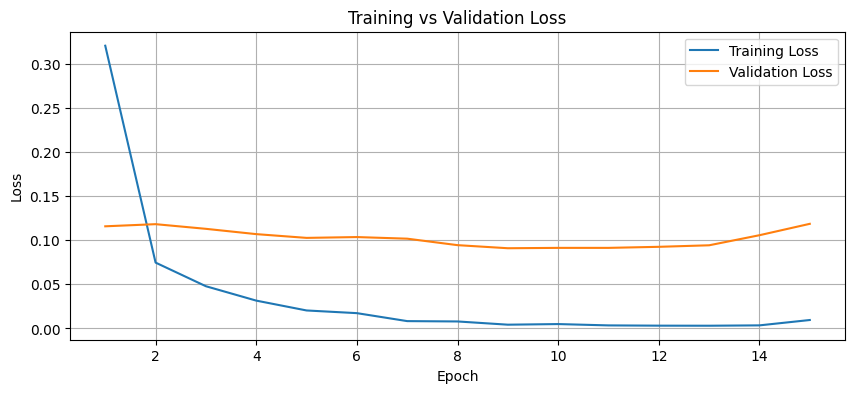

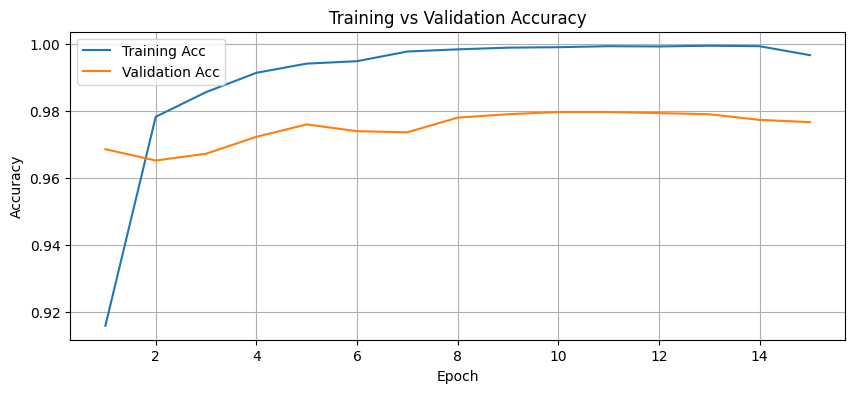

In [ ]:
Diagram()

===== KESIMPULAN =====


Model ConvNeXt dapat dikatakan bagus karena dari awal epoch, model mampu menyetak akurasi baik training maupun validasi di atas 90%. Melalui hasil macro classification metrics yang setara baik accuracy, precision, recall, maupun f1-score yaitu sebesar 97% - 98%, model mampu membedakan antarkelas dengan baik meskipun jumlah kelas pada dataset tidak seimbang. Hal ini didukung oleh hasil confusion matrix, di mana sangat sedikit kasus di mana model kebingungan membedakan kelas ini dengan kelas lain. Namun, kemampuan generalisasi model ini tetap dapat dikembangkan karena melalui grafik perbandingan akurasi/loss antara training dan validasi, performa training hampir sempurna secara akurasi tetapi stagnan pada validasi (gap antara loss training dan validasi cukup besar). Hal ini menandakan bahwa model cenderung "menghafal mati" data pada training set sehingga kesulitan apabila bertemu dengan data baru pada validation set dan test set. Jadi, secara performa sudah bagus, namun kemampuan generalisasi tetap dapat ditingkatkan.

### Model 2 : EfficientNet B3

Siapkan model, fungsi optimisasi, serta scheduler. Fungsi optimisasi yang digunakan adalah AdamW sedangkan scheduler yang digunakan adalah Cosine Annealing. 

In [ ]:
model = ModelBuilder("EfficientNet B3", False).to(Device)

Optimizer = torch.optim.AdamW(model.parameters(), lr = LearningRate, weight_decay = WeigthDecay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = 10)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\justi/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:03<00:00, 13.0MB/s]


Train dan validasi model pilihan serta simpan riwayat akurasi dan loss model tersebut

In [ ]:
ModelTrainAndValidation("EfficientNet B3", model, Optimizer, scheduler)

[Epoch 01/15] Train Loss = 0.6586 | Train Accuracy = 0.8303 || Validation Loss =0.1556 | Validation Accuracy =0.9561


[Epoch 02/15] Train Loss = 0.1714 | Train Accuracy = 0.9485 || Validation Loss =0.1139 | Validation Accuracy =0.9663


[Epoch 03/15] Train Loss = 0.1070 | Train Accuracy = 0.9681 || Validation Loss =0.1014 | Validation Accuracy =0.9696


[Epoch 04/15] Train Loss = 0.0762 | Train Accuracy = 0.9781 || Validation Loss =0.0988 | Validation Accuracy =0.9710


[Epoch 05/15] Train Loss = 0.0561 | Train Accuracy = 0.9828 || Validation Loss =0.0900 | Validation Accuracy =0.9774


[Epoch 06/15] Train Loss = 0.0429 | Train Accuracy = 0.9879 || Validation Loss =0.0869 | Validation Accuracy =0.9754


[Epoch 07/15] Train Loss = 0.0363 | Train Accuracy = 0.9896 || Validation Loss =0.0882 | Validation Accuracy =0.9760


[Epoch 08/15] Train Loss = 0.0327 | Train Accuracy = 0.9913 || Validation Loss =0.0890 | Validation Accuracy =0.9757


[Epoch 09/15] Train Loss = 0.0300 | Train Accuracy = 0.9917 || Validation Loss =0.0865 | Validation Accuracy =0.9733


[Epoch 10/15] Train Loss = 0.0272 | Train Accuracy = 0.9926 || Validation Loss =0.0910 | Validation Accuracy =0.9750


[Epoch 11/15] Train Loss = 0.0233 | Train Accuracy = 0.9936 || Validation Loss =0.0874 | Validation Accuracy =0.9754


[Epoch 12/15] Train Loss = 0.0254 | Train Accuracy = 0.9928 || Validation Loss =0.0859 | Validation Accuracy =0.9737


[Epoch 13/15] Train Loss = 0.0247 | Train Accuracy = 0.9934 || Validation Loss =0.0879 | Validation Accuracy =0.9760


[Epoch 14/15] Train Loss = 0.0267 | Train Accuracy = 0.9920 || Validation Loss =0.0897 | Validation Accuracy =0.9760


[Epoch 15/15] Train Loss = 0.0219 | Train Accuracy = 0.9936 || Validation Loss =0.0947 | Validation Accuracy =0.9750


Evaluasi performa model dengan cara mengujinya dengan tambahan metrik evaluasi

In [ ]:
ModelTesting("Model Weight/EfficientNet B3.pt", "EfficientNet B3")

Accuracy  (macro): 0.971997857093811
Precision (macro): 0.9657016396522522
Recall    (macro): 0.971997857093811
F1        (macro): 0.9687076210975647
Confusion matrix:
 [[138   0   0   0   0   2   0   0   0   1]
 [  0 149   0   0   0   0   0   0   0   0]
 [  1   2 270   0   0   0   1   0   0   0]
 [  0   0   0 787   0   1   2   0   7   2]
 [  0   2   0   0 452   4   0   2   0   0]
 [  2   0   0   0   4 145   0   2   0   0]
 [  0   2   4   1   1   1 236   3   0   4]
 [  1   0   0   0   6   4   3 283   0   1]
 [  0   1   0   0   0   0   0   0 296   0]
 [  0   0   0   0   0   2   2   2   0 136]]


Plot grafik perbandingan loss dan akurasi train dan validasi model

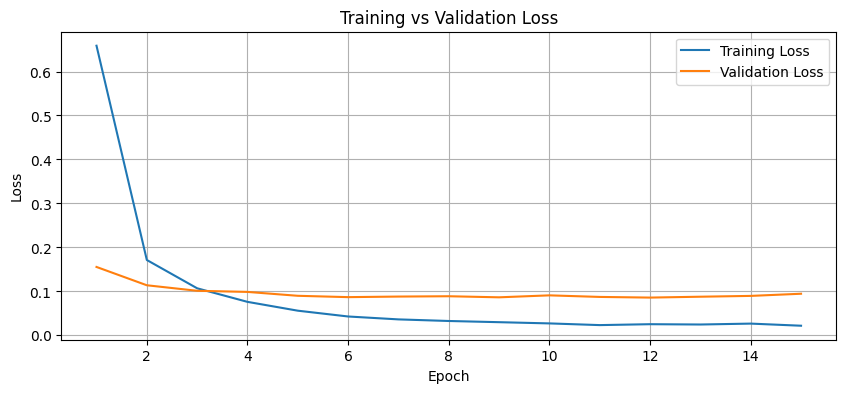

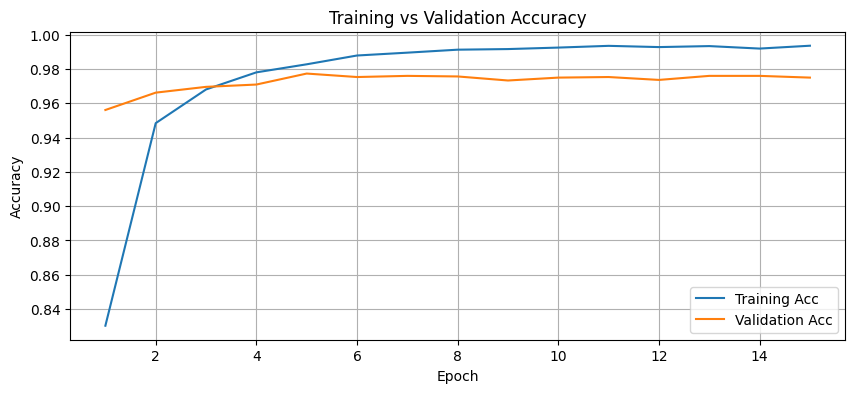

In [ ]:
Diagram()

===== KESIMPULAN =====

Model EfficientNet B3 juga dapat dikatakan sebagai model yang bagus. Meskipun pada awal epoch model memberikan akurasi training yang bagus, pada epoch selanjutnya model dapat memberikan akurasi training yang lebih tinggi dan mirip dengan ConvNeXt. Model ini juga memiliki macro classification metrics yang setara baik accuracy, precision, recall, maupun f1-score. Namun, persentase yang didapatkan sedikit kurang dibandingkan persentase yang dimiliki ConvNeXt. Confusion matrix juga memperlihatkan bahwa EfficientNet B3 sedikit lebih bingung dalam membedakan antarkelas daripada ConvNeXt. Namun meskipun baik ConvNeXt maupun EfficientNet B3 memiliki kasus dan permasalahan generalisasi yang sama jika ditinjau dari grafik, gap loss antara training dan validasi pada EfficientNet B3 lebih kecil dibandingkan ConvNeXt (Gap akurasi tidak ada bedanya dengan ConvNeXt). 

### Model 3 : ResNet50

Siapkan model, fungsi optimisasi, serta scheduler. Fungsi optimisasi yang digunakan adalah AdamW sedangkan scheduler yang digunakan adalah Cosine Annealing. 

In [ ]:
model = ModelBuilder("ResNet50", False).to(Device)

Optimizer = torch.optim.AdamW(model.parameters(), lr = LearningRate, weight_decay = WeigthDecay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = 10)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\justi/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:08<00:00, 12.8MB/s]


Train dan validasi model pilihan serta simpan riwayat akurasi dan loss model tersebut

In [ ]:
ModelTrainAndValidation("ResNet50", model, Optimizer, scheduler)

[Epoch 01/15] Train Loss = 0.3910 | Train Accuracy = 0.8836 || Validation Loss =0.1913 | Validation Accuracy =0.9406


[Epoch 02/15] Train Loss = 0.2023 | Train Accuracy = 0.9385 || Validation Loss =0.1961 | Validation Accuracy =0.9420


[Epoch 03/15] Train Loss = 0.1474 | Train Accuracy = 0.9523 || Validation Loss =0.1797 | Validation Accuracy =0.9501


[Epoch 04/15] Train Loss = 0.0926 | Train Accuracy = 0.9717 || Validation Loss =0.1504 | Validation Accuracy =0.9615


[Epoch 05/15] Train Loss = 0.0670 | Train Accuracy = 0.9809 || Validation Loss =0.1506 | Validation Accuracy =0.9588


[Epoch 06/15] Train Loss = 0.0427 | Train Accuracy = 0.9871 || Validation Loss =0.1263 | Validation Accuracy =0.9652


[Epoch 07/15] Train Loss = 0.0313 | Train Accuracy = 0.9911 || Validation Loss =0.1155 | Validation Accuracy =0.9717


[Epoch 08/15] Train Loss = 0.0170 | Train Accuracy = 0.9954 || Validation Loss =0.1151 | Validation Accuracy =0.9703


[Epoch 09/15] Train Loss = 0.0145 | Train Accuracy = 0.9965 || Validation Loss =0.1038 | Validation Accuracy =0.9730


[Epoch 10/15] Train Loss = 0.0111 | Train Accuracy = 0.9970 || Validation Loss =0.1035 | Validation Accuracy =0.9727


[Epoch 11/15] Train Loss = 0.0109 | Train Accuracy = 0.9975 || Validation Loss =0.1041 | Validation Accuracy =0.9740


[Epoch 12/15] Train Loss = 0.0094 | Train Accuracy = 0.9978 || Validation Loss =0.1021 | Validation Accuracy =0.9723


[Epoch 13/15] Train Loss = 0.0116 | Train Accuracy = 0.9973 || Validation Loss =0.1010 | Validation Accuracy =0.9727


[Epoch 14/15] Train Loss = 0.0120 | Train Accuracy = 0.9965 || Validation Loss =0.1152 | Validation Accuracy =0.9737


[Epoch 15/15] Train Loss = 0.0324 | Train Accuracy = 0.9902 || Validation Loss =0.1498 | Validation Accuracy =0.9626


Evaluasi performa model dengan cara mengujinya dengan tambahan metrik evaluasi

In [ ]:
ModelTesting("Model Weight/ResNet50.pt", "ResNet50")

Accuracy  (macro): 0.9651820659637451
Precision (macro): 0.9621943235397339
Recall    (macro): 0.9651820659637451
F1        (macro): 0.9635956883430481
Confusion matrix:
 [[139   0   0   0   1   0   1   0   0   0]
 [  0 148   1   0   0   0   0   0   0   0]
 [  0   0 271   0   0   0   3   0   0   0]
 [  0   0   1 788   0   0   0   2   7   1]
 [  0   1   0   0 446   4   0   8   0   1]
 [  2   0   0   0   5 141   1   4   0   0]
 [  0   1   3   4   0   0 236   1   0   7]
 [  0   1   4   0   6   4   0 280   0   3]
 [  0   2   0   1   0   1   0   0 293   0]
 [  0   0   0   1   1   2   1   2   1 134]]


Plot grafik perbandingan loss dan akurasi train dan validasi model

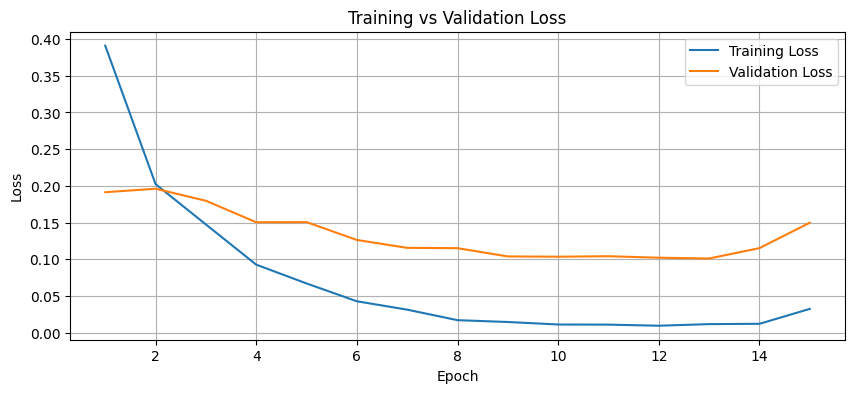

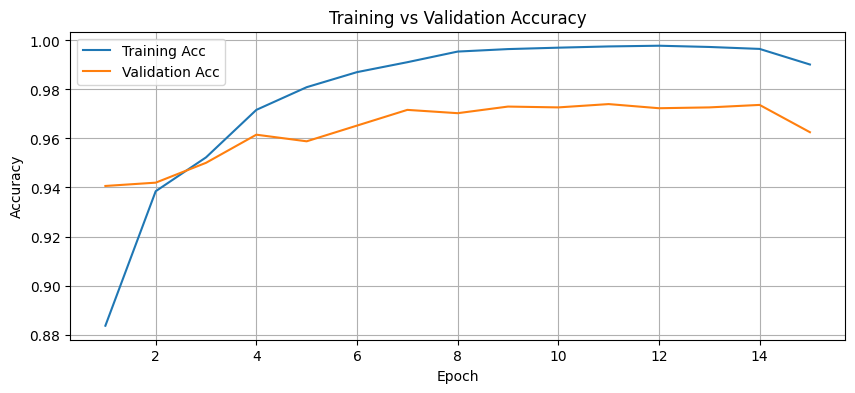

In [ ]:
Diagram()

===== KESIMPULAN =====


Model ResNet50 juga dapat dikatakan sebagai model yang bagus karena hasil macro classification metrics yang setara baik accuracy, precision, recall, maupun f1-score yaitu sebesar 96% - 97%. Model juga mampu membedakan antarkelas dengan baik meskipun jumlah kelas pada dataset tidak seimbang. Hal ini didukung oleh hasil confusion matrix, di mana sangat sedikit kasus di mana model kebingungan membedakan kelas ini dengan kelas lain. Namun secara keseluruhan, model ResNet50 memiliki performa yang kalah unggul jika dibandingkan dengan model EfficientNet B3 dan ConvNeXt. Untuk permasalahan generalisasi, grafik menunjukan bahwa gap akurasi yang dihasilkan antara training dan validasi sedikit lebih besar dibandingkan kedua model EfficientNet B3 dan ConvNeXt

### Kesimpulan Model

Model terbaik dipilih berdasarkan persentase Macro F1-Score terbesar. Alasan pemilihan Macro F1-Score sebagai penentu model terbaik adalah karena metrik tersebut menganggap bahwa semua kelas baik mayoritas maupun minoritas setara dan sama pentingnya. Oleh karena itu, Macro F1-Score sangat cocok digunakan pada kasus dataset yang tidak seimbang karena menyajikan evaluasi yang seimbang terhadap dataset dengan distribusi tidak seimbang. Metrik tersebut juga memastikan baik Precision maupun Recall diperhatikan memungkinkan pengelihatan terhadap seberapa baik kemampuan generalisasi model.

Berdasarkan hasil training hinggal evaluasi ketiga model, berikut merupakan hasil Macro F1-Score ketiga model :

ConvNeXt        : 0.9748  
EfficientNet B3 : 0.9687  
ResNet50        : 0.9636

Untuk itu, melalui hasil Macro F1-Score, model terbaik jatuh kepada ConvNeXt. Model ini akan dijadikan model pilihan untuk permasalahan klasifikasi sampah dan akan dioptimisasikan untuk hasil yang lebih maksimal

## Optimisasi

Setelah pemilihan model terbaik, yaitu ConvNeXt, model pilihan akan dioptimisasi untuk meningkatkan performanya. Berdasarkan hasil training dan evaluasi menggunakan hyperparameter dasar, kemampuan generalisasi model masih dapat ditingkatkan lagi. 

### Optimisasi 1 : Pemisahan Backbone dan Head

Model CNN terdiri atas dua bagian, yaitu Feature Extraction dan Fully Connected Layers. Feature Extraction biasanya disebut sebagai Backbone, dilengkapi oleh convolution/filters dan pooling yang berperan dalam mengekstrak fitur-fitur penting seperti bentuk, tekstur, dan sisi. Sedangkan Fully Connected Layers biasanya disebut sebagai Head yang berperan dalam melakukan perhitungan layaknya Neural Networks biasa untuk memberikan prediksi akhir. 

#### Pengaturan Backbone dan Head

Alasan Head dan Backbone dipisah adalah karena model ConvNeXt telah melalui proses pre-trained melalui ImageNet. Artinya, model memang sudah dilatih fundamental dalam mengekstrak fitur-fitur penting sebuah gambar sehingga weights yang ditetapkan sudah cocok. Untuk itu, Backbone biasanya dibekukan dengan kata lain tidak diikutsertakan dalam Backpropagation. Kalaupun diikutsertakan biasanya dilelehkan stage demi stage dengan learning rate yang rendah. Sedangkan Head lebih fleksibel karena weights yang ditetapkan diacak (hal ini dikarenakan head selalu dilepas karena penyesuaian jumlah output/kelas). Artinya, head memerlukan proses belajar yang lebih intensif dibandingkan Backbone sehingga memerlukan learning rate yang lebih tinggi. Umumnya rasio learning rate antara Backbone dan Head adalah 10 : 1

In [45]:
def FreezeAll(model):

    for ParameterName, ModelParameter in model.named_parameters():
        ModelParameter.requires_grad = False

def UnfreezeHead(model):

    for ModelParameter in model.classifier[2].parameters():
        ModelParameter.requires_grad = True

def UnfreezeBackbone(model, stages):

    for i in stages:
        for ModelParameter in model.features[i].parameters():
            ModelParameter.requires_grad = True

Hyperparameter Model

In [49]:
WeightDecayBackbone = 1e-5
WeightDecayHead = 1e-4
LearningRateBackbone = 1e-5
LearningRateHead = 1e-4
Epochs = 15

#### Eksperimen 1 : Pembekuan Semua Backbone

Siapkan model pilihan untuk optimisasi

In [46]:
model = ModelBuilder("ConvNeXt", False).to(Device)

Pertama-tama, semua bagian dibekukan terlebih dahulu. Lalu, mulai dengan melelehkan bagian Head model

In [47]:
FreezeAll(model)

UnfreezeHead(model)

Selanjutnya, parameter-parameter yang akan di-train disimpan

In [48]:
BackboneParameters = []
HeadParameters = []

for ParameterName, ModelParameter in model.named_parameters():

    if not ModelParameter.requires_grad:
        continue
    
    if ParameterName.startswith("fc."):
        HeadParameters.append(ModelParameter)
    else:
        BackboneParameters.append(ModelParameter)

Daftarkan bagian model CNN yang akan masuk training

In [50]:
GoesToTrainStructure = []

if BackboneParameters:
    
    GoesToTrainStructure.append({

        "params": BackboneParameters, 
        "lr": LearningRateBackbone, 
        "weight_decay": WeightDecayBackbone
        
        })

if HeadParameters:

    GoesToTrainStructure.append({

        "params": HeadParameters,     
        "lr": LearningRateHead,
        "weight_decay": WeightDecayHead
        
        })

Siapkan fungsi optimisasi dan scheduler. Fungsi optimisasi yang digunakan adalah AdamW sedangkan scheduler yang digunakan adalah Cosine Annealing. 

In [51]:
Optimizer = torch.optim.AdamW(GoesToTrainStructure)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = 10)

Train dan validasi model pilihan serta simpan riwayat akurasi dan loss model tersebut

In [52]:
ModelTrainAndValidation("ConvNeXt", model, Optimizer, scheduler)

[Epoch 01/15] Train Loss = 2.2119 | Train Accuracy = 0.2091 || Validation Loss =2.0194 | Validation Accuracy =0.4113


[Epoch 02/15] Train Loss = 1.9425 | Train Accuracy = 0.4916 || Validation Loss =1.7457 | Validation Accuracy =0.6916


[Epoch 03/15] Train Loss = 1.7148 | Train Accuracy = 0.6816 || Validation Loss =1.5247 | Validation Accuracy =0.8067


[Epoch 04/15] Train Loss = 1.5335 | Train Accuracy = 0.7568 || Validation Loss =1.3561 | Validation Accuracy =0.8441


[Epoch 05/15] Train Loss = 1.4018 | Train Accuracy = 0.7928 || Validation Loss =1.2316 | Validation Accuracy =0.8640


[Epoch 06/15] Train Loss = 1.3058 | Train Accuracy = 0.8065 || Validation Loss =1.1462 | Validation Accuracy =0.8742


[Epoch 07/15] Train Loss = 1.2393 | Train Accuracy = 0.8204 || Validation Loss =1.0910 | Validation Accuracy =0.8809


[Epoch 08/15] Train Loss = 1.1913 | Train Accuracy = 0.8314 || Validation Loss =1.0591 | Validation Accuracy =0.8839


[Epoch 09/15] Train Loss = 1.1694 | Train Accuracy = 0.8326 || Validation Loss =1.0446 | Validation Accuracy =0.8860


[Epoch 10/15] Train Loss = 1.1682 | Train Accuracy = 0.8320 || Validation Loss =1.0409 | Validation Accuracy =0.8860


[Epoch 11/15] Train Loss = 1.1731 | Train Accuracy = 0.8297 || Validation Loss =1.0409 | Validation Accuracy =0.8860


[Epoch 12/15] Train Loss = 1.1665 | Train Accuracy = 0.8290 || Validation Loss =1.0371 | Validation Accuracy =0.8870


[Epoch 13/15] Train Loss = 1.1547 | Train Accuracy = 0.8334 || Validation Loss =1.0221 | Validation Accuracy =0.8877


[Epoch 14/15] Train Loss = 1.1347 | Train Accuracy = 0.8352 || Validation Loss =0.9909 | Validation Accuracy =0.8893


[Epoch 15/15] Train Loss = 1.0889 | Train Accuracy = 0.8421 || Validation Loss =0.9425 | Validation Accuracy =0.8941


Evaluasi performa model dengan cara mengujinya dengan tambahan metrik evaluasi

In [53]:
ModelTesting("Model Weight/ConvNeXt.pt", "ConvNeXt")

Accuracy  (macro): 0.847814679145813
Precision (macro): 0.8282181024551392
Recall    (macro): 0.847814679145813
F1        (macro): 0.835870087146759
Confusion matrix:
 [[134   0   2   0   2   2   0   0   0   1]
 [  2 141   0   1   1   1   1   1   0   1]
 [  6   2 247   0   1   0  16   2   0   0]
 [  2   2   9 763   0   1   4   6   7   5]
 [  0   5   3   0 381  28   1  35   3   4]
 [  6   6   6   0  13 109   4   6   1   2]
 [  6   1  23  10   0   6 183   5   2  16]
 [  2   3  14   3  14  12   4 236   1   9]
 [  1   2   0   0   2   0   0   0 292   0]
 [ 12   3   6   3   0   8   9   1   3  97]]


Plot grafik perbandingan loss dan akurasi train dan validasi model

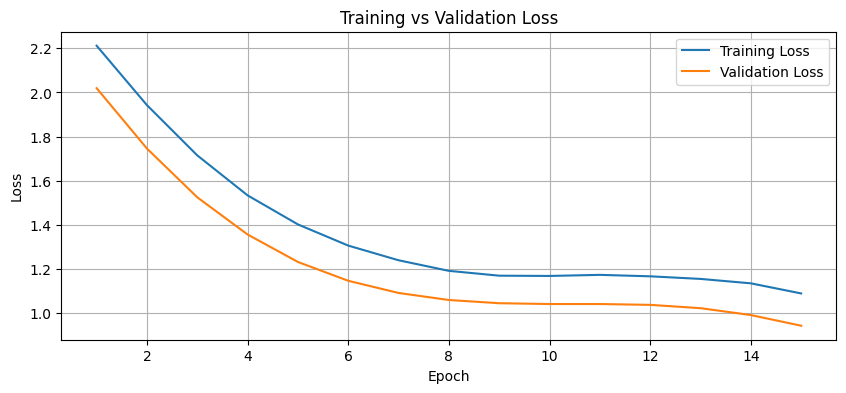

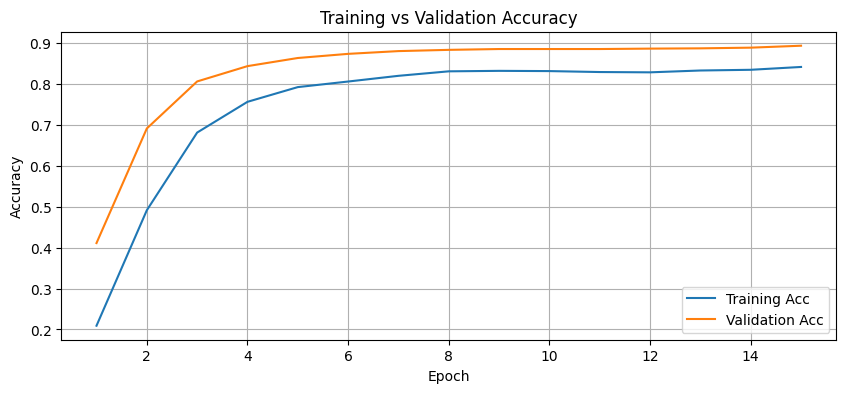

In [54]:
Diagram()

=== KESIMPULAN ===

Hasil akhir menunjukan bahwa performa model jauh lebih buruk jika ditambahkan pemisahan Head dan Backbone dengan nilai Macro F1-Score sebesar 0.8358. Namun di sisi lain, grafik menunjukan bahwa gap akurasi/loss antara training dan validasi lebih kecil dengan metode ini.

#### Eksperimen 2 : Melelehkan Stage Terakhir Backbone

Selanjutnya, sebagian backbone akan dilelehkan untuk melihat apakah ada perkembangan karena sebelumnya model memberikan performa yang jauh lebih buruk jika hanya head saja yang dilelehkan.

In [61]:
model = ModelBuilder("ConvNeXt", False).to(Device)

Kali ini, backbone akan dibuka mulai dari stage terakhir saja

In [62]:
FreezeAll(model)

UnfreezeHead(model)

UnfreezeBackbone(model, [7])

Selanjutnya, parameter-parameter yang akan di-train disimpan

In [63]:
BackboneParameters = []
HeadParameters = []

for ParameterName, ModelParameter in model.named_parameters():

    if not ModelParameter.requires_grad:
        continue
    
    if ParameterName.startswith("fc."):
        HeadParameters.append(ModelParameter)
    else:
        BackboneParameters.append(ModelParameter)

Daftarkan bagian model CNN yang akan masuk training

In [65]:
GoesToTrainStructure = []

if BackboneParameters:
    
    GoesToTrainStructure.append({

        "params": BackboneParameters, 
        "lr": LearningRateBackbone, 
        "weight_decay": WeightDecayBackbone
        
        })

if HeadParameters:

    GoesToTrainStructure.append({

        "params": HeadParameters,     
        "lr": LearningRateHead,
        "weight_decay": WeightDecayHead
        
        })

Siapkan fungsi optimisasi dan scheduler. Fungsi optimisasi yang digunakan adalah AdamW sedangkan scheduler yang digunakan adalah Cosine Annealing. 

In [66]:
Optimizer = torch.optim.AdamW(GoesToTrainStructure)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = 10)

Train dan validasi model pilihan serta simpan riwayat akurasi dan loss model tersebut

In [67]:
ModelTrainAndValidation("ConvNeXt", model, Optimizer, scheduler)

[Epoch 01/15] Train Loss = 1.5779 | Train Accuracy = 0.6133 || Validation Loss =0.6809 | Validation Accuracy =0.8968


[Epoch 02/15] Train Loss = 0.5896 | Train Accuracy = 0.8878 || Validation Loss =0.2919 | Validation Accuracy =0.9315


[Epoch 03/15] Train Loss = 0.3721 | Train Accuracy = 0.9159 || Validation Loss =0.2051 | Validation Accuracy =0.9477


[Epoch 04/15] Train Loss = 0.2880 | Train Accuracy = 0.9336 || Validation Loss =0.1712 | Validation Accuracy =0.9534


[Epoch 05/15] Train Loss = 0.2467 | Train Accuracy = 0.9403 || Validation Loss =0.1575 | Validation Accuracy =0.9558


[Epoch 06/15] Train Loss = 0.2216 | Train Accuracy = 0.9451 || Validation Loss =0.1466 | Validation Accuracy =0.9575


[Epoch 07/15] Train Loss = 0.1999 | Train Accuracy = 0.9521 || Validation Loss =0.1421 | Validation Accuracy =0.9609


[Epoch 08/15] Train Loss = 0.1923 | Train Accuracy = 0.9531 || Validation Loss =0.1400 | Validation Accuracy =0.9599


[Epoch 09/15] Train Loss = 0.1827 | Train Accuracy = 0.9575 || Validation Loss =0.1378 | Validation Accuracy =0.9605


[Epoch 10/15] Train Loss = 0.1806 | Train Accuracy = 0.9557 || Validation Loss =0.1377 | Validation Accuracy =0.9602


[Epoch 11/15] Train Loss = 0.1816 | Train Accuracy = 0.9573 || Validation Loss =0.1377 | Validation Accuracy =0.9602


[Epoch 12/15] Train Loss = 0.1853 | Train Accuracy = 0.9548 || Validation Loss =0.1373 | Validation Accuracy =0.9602


[Epoch 13/15] Train Loss = 0.1778 | Train Accuracy = 0.9581 || Validation Loss =0.1350 | Validation Accuracy =0.9615


[Epoch 14/15] Train Loss = 0.1694 | Train Accuracy = 0.9608 || Validation Loss =0.1320 | Validation Accuracy =0.9619


[Epoch 15/15] Train Loss = 0.1649 | Train Accuracy = 0.9593 || Validation Loss =0.1306 | Validation Accuracy =0.9619


Evaluasi performa model dengan cara mengujinya dengan tambahan metrik evaluasi

In [68]:
ModelTesting("Model Weight/ConvNeXt.pt", "ConvNeXt")

Accuracy  (macro): 0.9502854347229004
Precision (macro): 0.9378526210784912
Recall    (macro): 0.9502854347229004
F1        (macro): 0.943359375
Confusion matrix:
 [[137   0   0   0   0   3   0   1   0   0]
 [  0 148   0   0   0   1   0   0   0   0]
 [  1   0 258   0   0   0  12   3   0   0]
 [  0   0   0 784   0   2   3   0   8   2]
 [  0   1   1   0 420  14   0  21   0   3]
 [  0   0   0   0   5 147   0   1   0   0]
 [  1   0   5   5   0   4 224   5   0   8]
 [  0   1   5   0   7   2   1 276   0   6]
 [  0   1   0   0   0   0   0   0 296   0]
 [  1   0   2   0   0   3   2   2   0 132]]


Plot grafik perbandingan loss dan akurasi train dan validasi model

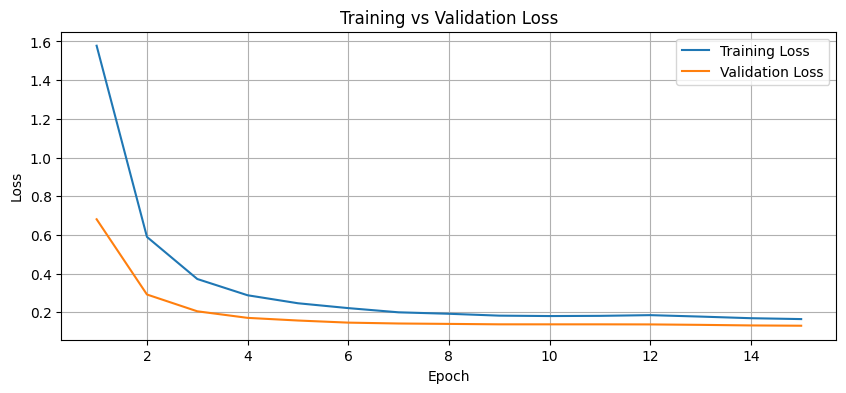

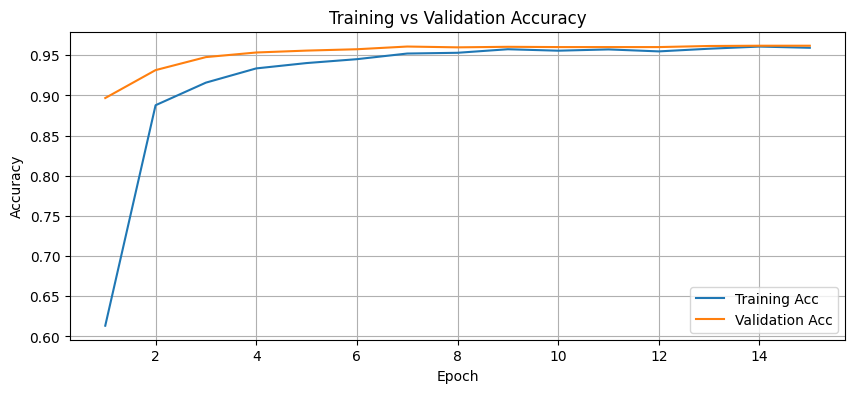

In [69]:
Diagram()

=== KESIMPULAN ===

Hasil akhir menunjukan bahwa performa model mengalami peningkatan. Dari 0.8358, dengan dilelehkannya stage terakhir pada backbone, model berhasil meraih Macro F1-Score sebesar 0.9434. Grafik juga menunjukan bahwa gap akurasi/loss antara training dan validasi sangat kecil yang merupakan perkembangan gap yang jauh lebih baik daripada pengaturan awal yang polos.

#### Eksperimen 3 : Melelehkan 3 Stage Terakhir Backbone

Selanjutnya, lebih banyak backbone akan dilelehkan untuk melihat apakah ada perkembangan karena sebelumnya model memberikan performa yang meningkat drastis setelah stage terakhir backbone dilelehkan

In [71]:
model = ModelBuilder("ConvNeXt", False).to(Device)

Kali ini, backbone akan dibuka mulai dari stage terakhir saja

In [72]:
FreezeAll(model)

UnfreezeHead(model)

UnfreezeBackbone(model, [5, 7])

Selanjutnya, parameter-parameter yang akan di-train disimpan

In [73]:
BackboneParameters = []
HeadParameters = []

for ParameterName, ModelParameter in model.named_parameters():

    if not ModelParameter.requires_grad:
        continue
    
    if ParameterName.startswith("fc."):
        HeadParameters.append(ModelParameter)
    else:
        BackboneParameters.append(ModelParameter)

Daftarkan bagian model CNN yang akan masuk training

In [75]:
GoesToTrainStructure = []

if BackboneParameters:
    
    GoesToTrainStructure.append({

        "params": BackboneParameters, 
        "lr": LearningRateBackbone, 
        "weight_decay": WeightDecayBackbone
        
        })

if HeadParameters:

    GoesToTrainStructure.append({

        "params": HeadParameters,     
        "lr": LearningRateHead,
        "weight_decay": WeightDecayHead
        
        })

Siapkan fungsi optimisasi dan scheduler. Fungsi optimisasi yang digunakan adalah AdamW sedangkan scheduler yang digunakan adalah Cosine Annealing. 

In [76]:
Optimizer = torch.optim.AdamW(GoesToTrainStructure)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = 10)

Train dan validasi model pilihan serta simpan riwayat akurasi dan loss model tersebut

In [77]:
ModelTrainAndValidation("ConvNeXt", model, Optimizer, scheduler)

[Epoch 01/15] Train Loss = 1.3040 | Train Accuracy = 0.6973 || Validation Loss =0.4778 | Validation Accuracy =0.9190


[Epoch 02/15] Train Loss = 0.4088 | Train Accuracy = 0.9124 || Validation Loss =0.2120 | Validation Accuracy =0.9474


[Epoch 03/15] Train Loss = 0.2362 | Train Accuracy = 0.9444 || Validation Loss =0.1568 | Validation Accuracy =0.9602


[Epoch 04/15] Train Loss = 0.1725 | Train Accuracy = 0.9566 || Validation Loss =0.1337 | Validation Accuracy =0.9646


[Epoch 05/15] Train Loss = 0.1362 | Train Accuracy = 0.9671 || Validation Loss =0.1192 | Validation Accuracy =0.9683


[Epoch 06/15] Train Loss = 0.1149 | Train Accuracy = 0.9730 || Validation Loss =0.1122 | Validation Accuracy =0.9703


[Epoch 07/15] Train Loss = 0.0935 | Train Accuracy = 0.9798 || Validation Loss =0.1101 | Validation Accuracy =0.9700


[Epoch 08/15] Train Loss = 0.0906 | Train Accuracy = 0.9803 || Validation Loss =0.1066 | Validation Accuracy =0.9703


[Epoch 09/15] Train Loss = 0.0857 | Train Accuracy = 0.9824 || Validation Loss =0.1048 | Validation Accuracy =0.9720


[Epoch 10/15] Train Loss = 0.0828 | Train Accuracy = 0.9837 || Validation Loss =0.1046 | Validation Accuracy =0.9723


[Epoch 11/15] Train Loss = 0.0819 | Train Accuracy = 0.9837 || Validation Loss =0.1046 | Validation Accuracy =0.9723


[Epoch 12/15] Train Loss = 0.0861 | Train Accuracy = 0.9811 || Validation Loss =0.1045 | Validation Accuracy =0.9720


[Epoch 13/15] Train Loss = 0.0900 | Train Accuracy = 0.9812 || Validation Loss =0.1038 | Validation Accuracy =0.9717


[Epoch 14/15] Train Loss = 0.0792 | Train Accuracy = 0.9837 || Validation Loss =0.1007 | Validation Accuracy =0.9733


[Epoch 15/15] Train Loss = 0.0739 | Train Accuracy = 0.9855 || Validation Loss =0.0980 | Validation Accuracy =0.9730


Evaluasi performa model dengan cara mengujinya dengan tambahan metrik evaluasi

In [78]:
ModelTesting("Model Weight/ConvNeXt.pt", "ConvNeXt")

Accuracy  (macro): 0.9605389833450317
Precision (macro): 0.9526855945587158
Recall    (macro): 0.9605389833450317
F1        (macro): 0.9563366770744324
Confusion matrix:
 [[138   0   0   0   0   2   0   1   0   0]
 [  0 148   0   0   0   0   0   1   0   0]
 [  0   0 264   0   0   0   8   1   0   1]
 [  0   0   0 785   0   2   2   0   8   2]
 [  0   1   0   0 442  10   0   7   0   0]
 [  1   0   0   0   4 145   0   3   0   0]
 [  0   0   7   3   1   3 230   1   0   7]
 [  0   1   3   0   4   4   1 280   0   5]
 [  0   0   0   0   1   0   1   1 294   0]
 [  0   0   0   0   0   2   4   3   0 133]]


Plot grafik perbandingan loss dan akurasi train dan validasi model

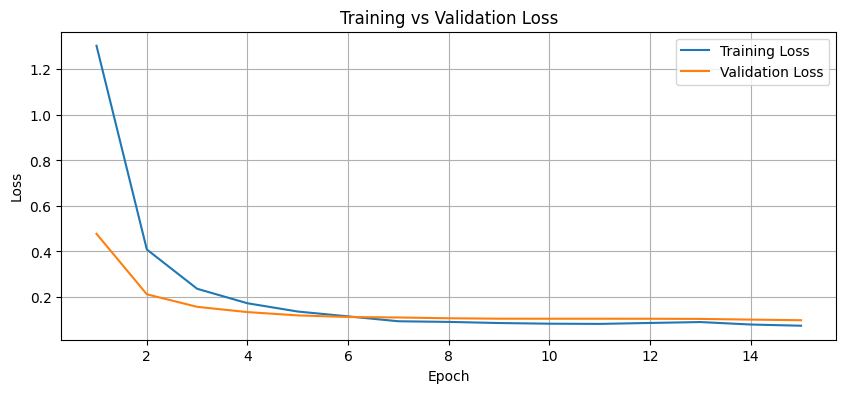

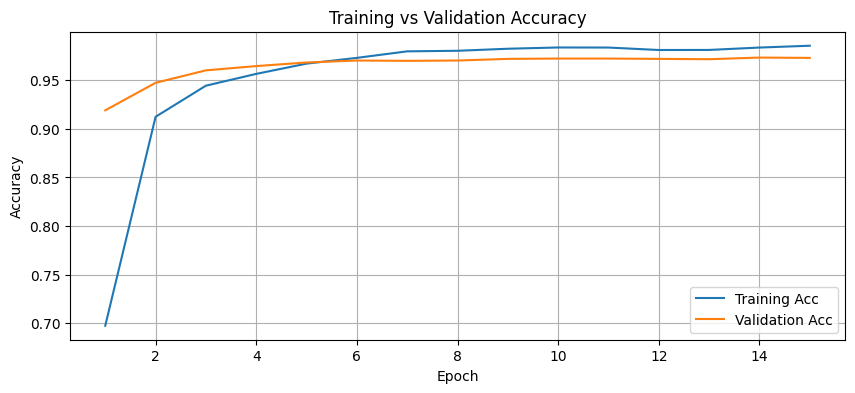

In [79]:
Diagram()

=== KESIMPULAN ===

Hasil akhir menunjukan bahwa performa model mengalami peningkatan. Dari 0.9434, dengan dilelehkannya 3 stage terakhir pada backbone, model berhasil meraih Macro F1-Score sebesar 0.9563. Grafik juga menunjukan bahwa gap akurasi/loss antara training dan validasi sangat kecil yang merupakan perkembangan gap yang jauh lebih baik daripada pengaturan awal yang polos. Untuk itu, optimisasi 1 akan ditetapkan. Meskipun Macro F1-Score yang didapatkan lebih rendah, namun gap akurasi/loss antara training dan validasi sangat rendah yang artinya model memiliki risiko terkena overfitting yang lebih rendah dan peluang generalisasi yang lebih tinggi

### Optimisasi 2 : Penambahan Warmup

Warmup merupakan salah satu metode optimisasi di mana pada beberapa epoch pertama, model dilatih menggunakan learning rate yang rendah. Semakin bertambahnya epoch, learning rate model akan semakin meningkat hingga meraih learning rate yang ditetapkan di awal. Tujuan warmup adalah menjamin stabilitas model karena dengan learning rate yang relatif rendah di awal, model "tidak kaget" dan malah menyebabkan proses training yang tidak stabil dan divergensi. Jadi, warmup menjamin keamanan dan stabilitas apabila hendak menggunakan learning rate yang lebih tinggi sehingga risiko overfitting bisa ditekan dan generalisasi dapat ditingkatkan

In [80]:
model = ModelBuilder("ConvNeXt", False).to(Device)

Kali ini, backbone akan dibuka mulai dari stage terakhir saja

In [81]:
FreezeAll(model)

UnfreezeHead(model)

UnfreezeBackbone(model, [5, 7])

Selanjutnya, parameter-parameter yang akan di-train disimpan

In [82]:
BackboneParameters = []
HeadParameters = []

for ParameterName, ModelParameter in model.named_parameters():

    if not ModelParameter.requires_grad:
        continue
    
    if ParameterName.startswith("fc."):
        HeadParameters.append(ModelParameter)
    else:
        BackboneParameters.append(ModelParameter)

Daftarkan bagian model CNN yang akan masuk training

In [83]:
GoesToTrainStructure = []

if BackboneParameters:
    
    GoesToTrainStructure.append({

        "params": BackboneParameters, 
        "lr": LearningRateBackbone, 
        "weight_decay": WeightDecayBackbone
        
        })

if HeadParameters:

    GoesToTrainStructure.append({

        "params": HeadParameters,     
        "lr": LearningRateHead,
        "weight_decay": WeightDecayHead
        
        })

Siapkan fungsi optimisasi, yaitu AdamW

In [84]:
Optimizer = torch.optim.AdamW(GoesToTrainStructure)

Siapkan Scheduler dan Warmup. Umumnya, jumlah epoch warmup adalah 10% dari jumlah epoch training. Untuk scheduler yang digunakan adalah CosineAnnealing

In [85]:
WarmupEpochs = Epochs * 0.1

WarmUp = torch.optim.lr_scheduler.LinearLR(Optimizer, start_factor=0.2, total_iters = WarmupEpochs)

CosineAnnealing = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = Epochs - WarmupEpochs)

scheduler = torch.optim.lr_scheduler.SequentialLR(Optimizer, schedulers=[WarmUp, CosineAnnealing], milestones=[WarmupEpochs])

Train dan validasi model pilihan serta simpan riwayat akurasi dan loss model tersebut

In [87]:
ModelTrainAndValidation("ConvNeXt", model, Optimizer, scheduler)

[Epoch 01/15] Train Loss = 2.1203 | Train Accuracy = 0.2770 || Validation Loss =1.8794 | Validation Accuracy =0.5560


[Epoch 02/15] Train Loss = 1.1147 | Train Accuracy = 0.7846 || Validation Loss =0.4462 | Validation Accuracy =0.9163


[Epoch 03/15] Train Loss = 0.4327 | Train Accuracy = 0.9056 || Validation Loss =0.2205 | Validation Accuracy =0.9457


[Epoch 04/15] Train Loss = 0.2766 | Train Accuracy = 0.9378 || Validation Loss =0.1523 | Validation Accuracy =0.9609


[Epoch 05/15] Train Loss = 0.2068 | Train Accuracy = 0.9503 || Validation Loss =0.1353 | Validation Accuracy =0.9619


[Epoch 06/15] Train Loss = 0.1652 | Train Accuracy = 0.9600 || Validation Loss =0.1158 | Validation Accuracy =0.9673


[Epoch 07/15] Train Loss = 0.1343 | Train Accuracy = 0.9678 || Validation Loss =0.1055 | Validation Accuracy =0.9683


[Epoch 08/15] Train Loss = 0.1096 | Train Accuracy = 0.9747 || Validation Loss =0.1058 | Validation Accuracy =0.9679


[Epoch 09/15] Train Loss = 0.0998 | Train Accuracy = 0.9798 || Validation Loss =0.1008 | Validation Accuracy =0.9700


[Epoch 10/15] Train Loss = 0.0863 | Train Accuracy = 0.9830 || Validation Loss =0.0966 | Validation Accuracy =0.9720


[Epoch 11/15] Train Loss = 0.0806 | Train Accuracy = 0.9832 || Validation Loss =0.0931 | Validation Accuracy =0.9740


[Epoch 12/15] Train Loss = 0.0755 | Train Accuracy = 0.9853 || Validation Loss =0.0922 | Validation Accuracy =0.9754


[Epoch 13/15] Train Loss = 0.0721 | Train Accuracy = 0.9838 || Validation Loss =0.0914 | Validation Accuracy =0.9740


[Epoch 14/15] Train Loss = 0.0706 | Train Accuracy = 0.9860 || Validation Loss =0.0906 | Validation Accuracy =0.9750


[Epoch 15/15] Train Loss = 0.0731 | Train Accuracy = 0.9850 || Validation Loss =0.0906 | Validation Accuracy =0.9747


Evaluasi performa model dengan cara mengujinya dengan tambahan metrik evaluasi

In [88]:
ModelTesting("Model Weight/ConvNeXt.pt", "ConvNeXt")

Accuracy  (macro): 0.963629424571991
Precision (macro): 0.9568307399749756
Recall    (macro): 0.963629424571991
F1        (macro): 0.9599117040634155
Confusion matrix:
 [[137   0   0   0   0   2   0   1   0   1]
 [  0 147   0   0   1   0   0   1   0   0]
 [  0   0 269   0   0   0   5   0   0   0]
 [  0   0   0 789   0   2   1   0   7   0]
 [  0   1   0   0 437  10   0  12   0   0]
 [  1   0   0   0   4 147   0   1   0   0]
 [  1   0   5   3   0   2 234   1   0   6]
 [  0   1   2   0   5   5   1 279   0   5]
 [  0   0   0   0   1   0   0   0 296   0]
 [  0   0   1   0   0   2   4   2   0 133]]


Plot grafik perbandingan loss dan akurasi train dan validasi model

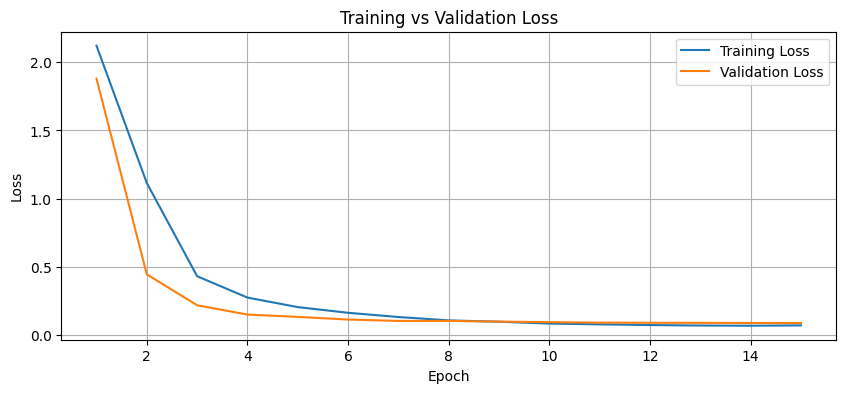

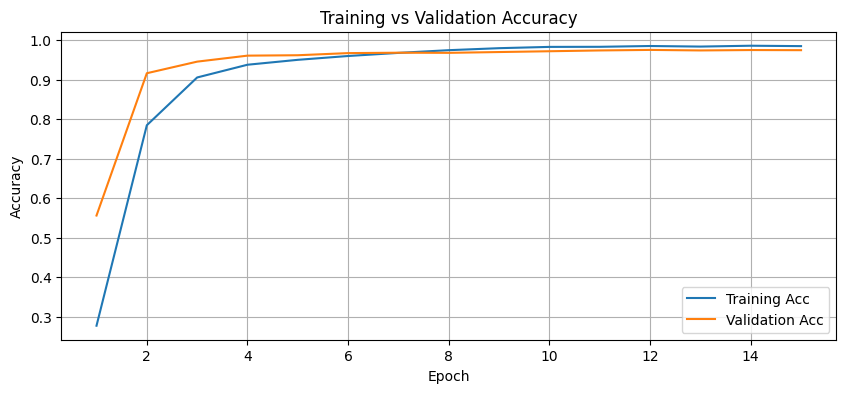

In [89]:
Diagram()

=== KESIMPULAN ===

Penggunaan Warm-Up berhasil meningkatkan performa model. Macro F1-Score yang diperoleh model sedikit lebih baik daripada tanpa Warm-Up. Lalu, gap akurasi/loss antara training dan validasi pun sangat kecil yang artinya model dapat melakukan generalisasi dengan baik.

### Optimisasi 3 : Hyperparameter Tuning

Sebagai optimisasi terakhir, hyperparameter tuning merupakan opsi terbaik. Parameter utama model seperti learning rate dan weight decay dimodifikasi sedikit untuk menambah sedikit performa akhir model

In [95]:
model = ModelBuilder("ConvNeXt", False).to(Device)

Lelehkan 3 stage terakhir backbone

In [96]:
FreezeAll(model)

UnfreezeHead(model)

UnfreezeBackbone(model, [5, 7])

Selanjutnya, parameter-parameter yang akan di-train disimpan

In [97]:
BackboneParameters = []
HeadParameters = []

for ParameterName, ModelParameter in model.named_parameters():

    if not ModelParameter.requires_grad:
        continue
    
    if ParameterName.startswith("fc."):
        HeadParameters.append(ModelParameter)
    else:
        BackboneParameters.append(ModelParameter)

Sebagai optimisasi ketiga, learning rate akan ditambahkan diikuti dengan penambahan b1, b2, dan epsilon untuk mendukung Optimizer

In [98]:
WeightDecayBackbone = 1e-5
WeightDecayHead = 1e-4
LearningRateBackbone = 5e-5
LearningRateHead = 5e-4
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
Epochs = 15

Daftarkan bagian model CNN yang akan masuk training

In [99]:
GoesToTrainStructure = []

if BackboneParameters:
    
    GoesToTrainStructure.append({

        "params": BackboneParameters, 
        "lr": LearningRateBackbone, 
        "weight_decay": WeightDecayBackbone
        
        })

if HeadParameters:

    GoesToTrainStructure.append({

        "params": HeadParameters,     
        "lr": LearningRateHead,
        "weight_decay": WeightDecayHead
        
        })

Siapkan fungsi optimisasi AdamW

In [100]:
Optimizer = torch.optim.AdamW(GoesToTrainStructure, betas = (b1, b2), eps = epsilon)

Siapkan Scheduler dan Warmup. Scheduler yang digunakan adalah CosineAnnealing

In [101]:
WarmupEpochs = Epochs * 0.1

WarmUp = torch.optim.lr_scheduler.LinearLR(Optimizer, start_factor=0.2, total_iters = WarmupEpochs)

CosineAnnealing = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = Epochs - WarmupEpochs)

scheduler = torch.optim.lr_scheduler.SequentialLR(Optimizer, schedulers=[WarmUp, CosineAnnealing], milestones=[WarmupEpochs])

Train dan validasi model pilihan serta simpan riwayat akurasi dan loss model tersebut

In [103]:
ModelTrainAndValidation("ConvNeXt", model, Optimizer, scheduler)

[Epoch 01/15] Train Loss = 0.6826 | Train Accuracy = 0.8831 || Validation Loss =0.2921 | Validation Accuracy =0.9369


[Epoch 02/15] Train Loss = 0.1997 | Train Accuracy = 0.9502 || Validation Loss =0.1074 | Validation Accuracy =0.9703


[Epoch 03/15] Train Loss = 0.0909 | Train Accuracy = 0.9774 || Validation Loss =0.0938 | Validation Accuracy =0.9727


[Epoch 04/15] Train Loss = 0.0519 | Train Accuracy = 0.9874 || Validation Loss =0.0874 | Validation Accuracy =0.9764


[Epoch 05/15] Train Loss = 0.0408 | Train Accuracy = 0.9901 || Validation Loss =0.0874 | Validation Accuracy =0.9744


[Epoch 06/15] Train Loss = 0.0307 | Train Accuracy = 0.9931 || Validation Loss =0.0877 | Validation Accuracy =0.9757


[Epoch 07/15] Train Loss = 0.0223 | Train Accuracy = 0.9949 || Validation Loss =0.0798 | Validation Accuracy =0.9784


[Epoch 08/15] Train Loss = 0.0149 | Train Accuracy = 0.9964 || Validation Loss =0.0800 | Validation Accuracy =0.9811


[Epoch 09/15] Train Loss = 0.0128 | Train Accuracy = 0.9971 || Validation Loss =0.0900 | Validation Accuracy =0.9787


[Epoch 10/15] Train Loss = 0.0126 | Train Accuracy = 0.9970 || Validation Loss =0.0843 | Validation Accuracy =0.9791


[Epoch 11/15] Train Loss = 0.0117 | Train Accuracy = 0.9975 || Validation Loss =0.0810 | Validation Accuracy =0.9814


[Epoch 12/15] Train Loss = 0.0084 | Train Accuracy = 0.9983 || Validation Loss =0.0805 | Validation Accuracy =0.9818


[Epoch 13/15] Train Loss = 0.0074 | Train Accuracy = 0.9990 || Validation Loss =0.0794 | Validation Accuracy =0.9828


[Epoch 14/15] Train Loss = 0.0079 | Train Accuracy = 0.9984 || Validation Loss =0.0819 | Validation Accuracy =0.9828


[Epoch 15/15] Train Loss = 0.0063 | Train Accuracy = 0.9988 || Validation Loss =0.0826 | Validation Accuracy =0.9828


Evaluasi performa model dengan cara mengujinya dengan tambahan metrik evaluasi

In [104]:
ModelTesting("Model Weight/ConvNeXt.pt", "ConvNeXt")

Accuracy  (macro): 0.9718167781829834
Precision (macro): 0.970051109790802
Recall    (macro): 0.9718167781829834
F1        (macro): 0.970761775970459
Confusion matrix:
 [[138   0   0   0   0   1   0   0   0   2]
 [  0 148   0   0   0   0   0   1   0   0]
 [  0   1 271   0   0   0   1   1   0   0]
 [  0   0   0 790   0   1   0   0   7   1]
 [  0   1   0   0 452   3   0   4   0   0]
 [  2   0   0   0   3 147   0   1   0   0]
 [  0   0   6   4   1   0 232   4   0   5]
 [  0   0   1   0   7   2   0 284   0   4]
 [  0   0   0   2   1   0   1   0 293   0]
 [  0   0   0   0   0   0   2   2   1 137]]


Plot grafik perbandingan loss dan akurasi train dan validasi model

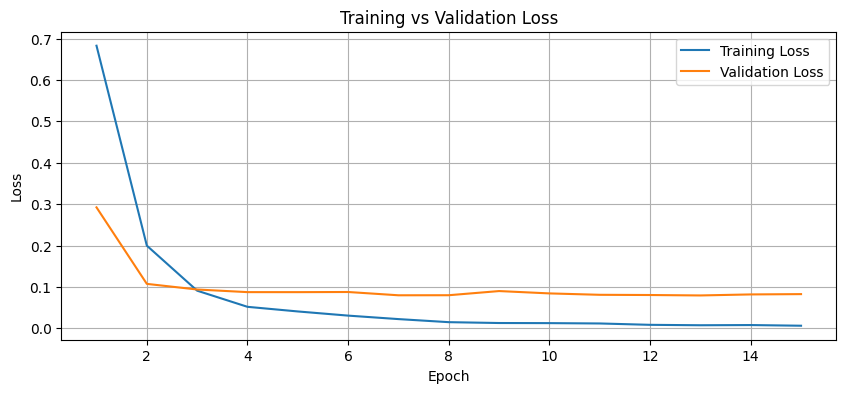

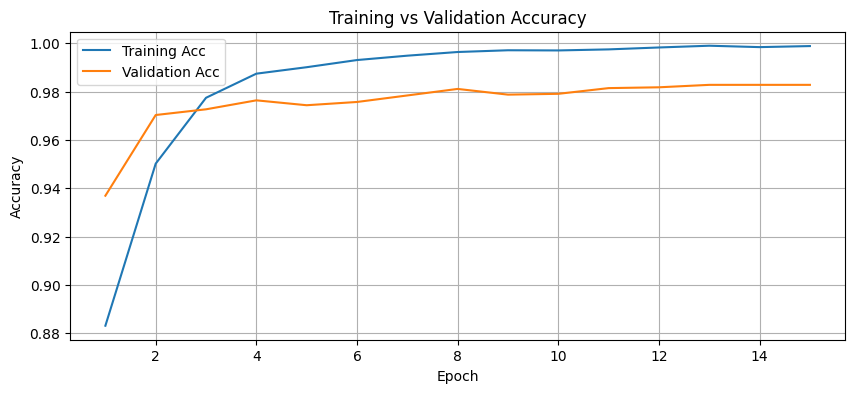

In [105]:
Diagram()

=== KESIMPULAN ===

Berdasarkan hasil akhir, hyperparameter tuning seperti peningkatan learning rate berhasil meningkatkan performa model ConvNeXt. Meskipun Macro F1-Score yang diperoleh sedikit lebih rendah daripada Macro F1-Score ConvNeXt dengan hyperparameter seadanya, namun optimisasi dipercaya dapat meningkatkan kemampuan model dalam melakukan generalisasi dengan baik. Untuk itu

## Penutup

Demikianlah alur percobaan yang diambil dalam memberikan solusi berbasis Machine Learning untuk klasifikasi jenis sampah. Alur yang diambil meliputi Exploratory Data Analysis, Data Preprocessing, Persiapan Model, Training dan Evaluasi model, hingga ketiga Optimisasi model terbaik. Hasilnya, model ConvNeXt diambil sebagai model terbaik dengan tiga optimisasi, yaitu pembekuan backbone stage awal hingga stage 4, penambahan warmup, dan hyperparameter tuning sehingga diperoleh hasil Macro F1-Score sebesar 0.9708. Meskipun performa model melalui Macro F1-Score sedikit lebih rendah, namun optimisasi diberlakukan untuk meningkatkan kemampuan generalisasi model ConvNeXt. Untuk itu, model ini dapat dijadikan solusi permasalahan yang diangkat dan dilanjutkan pada sesi dployment